<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/Continuity_Explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation of Analyzers using
This notebook will provide an example how to evaluate analyzers via translation of images.

The notebook is based on the following axiom:
Assuming the prediction function $f(x)$ is continious, then if two data points are nearly equivalent, then the explanations of their predictions should also be nearly equivalent.([Montavon et. al., 2018](https://reader.elsevier.com/reader/sd/pii/S1051200417302385?token=56EDF10BC4B2EE334D439DCD801F981B5B6953A2F821EA0CB38175B370AFF0BD8689F4CDD8411FF2E2D9CC997C533C46))
Explanation continuity (or lack of it) can be quantified by looking for the strongest variation of the explanation $R(x)$ in the input domain. This is called SVE (**S**trongest **V**ariation of **E**xplanation)

\begin{equation}
SVE=\max_{x \neq x'} \frac{\lVert R(x) - R(x') \lVert_1}{\lVert x - x' \lVert_2}
\end{equation}

If the technique satisfies explanation continuity, the explanations produced also must change continuously without sudden jumps.
Also a lower SVE indicates that the continuity holds for the given analyzer.

For a qualitative analysis a input image is translated horizontally from left to right. Then, for every translated image the prediction is saved and afterwards plotted into a diagram.

The analyzers used are based on the implementation of the [iNNvestigate Toolbox](https://arxiv.org/abs/1808.04260)

# Install iNNvestigate Toolbox

In [23]:
!pip install -q git+https://github.com/albermax/innvestigate
!pip install -q deeplift
!git clone https://github.com/infomon/understanding_cnn
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_mnist.py"):
  shutil.move("/content/understanding_cnn/utils/utils_mnist.py", "/content")
if not os.path.isfile("MNISTcnn.h5"):
  shutil.move("/content/understanding_cnn/models/pretrained_models/MNISTcnn.h5", "/content")
!rm -r understanding_cnn

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 102 (delta 36), reused 72 (delta 15), pack-reused 0
Receiving objects: 100% (102/102), 14.81 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (36/36), done.


# Imports

In [24]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
%matplotlib inline  

import imp
import matplotlib.pyplot as plt
import numpy as np
import cv2

from keras.models import load_model

import innvestigate
import innvestigate.utils as iutils

mnistutils = imp.load_source("utils_mnist", "utils_mnist.py")

# Data
Then, the MNIST data is loaded in its entirety, formatted according to the specifications of the Keras backend.

In [0]:
#load data
data_not_preprocessed = mnistutils.fetch_data()

#create reprocessing functions
input_range = [-1,1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

#preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

n = 10
test_images = list(zip(data[2][:n], data[3][:n]))


# Model
The next part loads are pretained CNN on MNIST and a "softmax-less" model is generated.

In [0]:
model = load_model('MNISTcnn.h5')
model.get_layer(name='dense_1').name='dense_1a'
model.get_layer(name='conv2d_1').name = 'conv2d_1a'
model.get_layer(name='conv2d_2').name = 'conv2d_2a'

#create momdel without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Setup analyzers

In [0]:
noise_scale = (input_range[1] - input_range[0]) * 0.1
ri = input_range[0]  # reference input

In [0]:
# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Function
    ("gradient", {"postprocess": "abs"}, mnistutils.graymap, "Gradient"),  # 0
    ("smoothgrad", {"noise_scale": noise_scale,
                    "postprocess": "square"}, mnistutils.graymap, "SmoothGrad"),  # 1

    # Signal
    ("deconvnet", {}, mnistutils.bk_proj, "Deconvnet"),  # 2
    ("guided_backprop", {}, mnistutils.bk_proj, "Guided Backprop",),  # 3
    ("pattern.net", {"pattern_type": "relu"}, mnistutils.bk_proj, "PatternNet"),  # 4

    # Interaction
    ("pattern.attribution", {"pattern_type": "relu"}, mnistutils.heatmap, "PatternAttribution"),  # 5
    ("deep_taylor.bounded", {"low": input_range[0],
                                 "high": input_range[1]}, mnistutils.heatmap, "DeepTaylor"),  # 6
    ("input_t_gradient", {}, mnistutils.heatmap, "Input * Gradient"),  # 7
    ("integrated_gradients", {"reference_inputs": ri}, mnistutils.heatmap, "Integrated Gradients"),  # 8
    ("lrp.z", {}, mnistutils.heatmap, "LRP-Z"),  # 9
    ("lrp.epsilon", {"epsilon": 1}, mnistutils.heatmap, "LRP-Epsilon"),  # 10
    ("lrp.epsilon_IB", {"epsilon": 1}, mnistutils.heatmap, "LRP-Epsilon"),  # 11
    ("lrp.alpha_1_beta_0", {}, mnistutils.heatmap, "LRP-Alpha1-Beta0"),  # 12
    ("lrp.alpha_1_beta_0_IB", {}, mnistutils.heatmap, "LRP-Alpha1-Beta0 IB"),  # 13
    ("lrp.alpha_2_beta_1", {}, mnistutils.heatmap, "LRP-Alpha2-Beta1"),  # 14
    ("lrp.alpha_2_beta_1_IB", {}, mnistutils.heatmap, "LRP-Alpha2-Beta1 IB"),  # 15
    ]

In [30]:
# Select methods of your choice
selected_methods_indices = [10,11,12,13,14,15]
selected_methods = [methods[i] for i in selected_methods_indices]
print('Using method(s) "{}".'.format([method[0] for method in selected_methods]))
methods = selected_methods

Using method(s) "['lrp.epsilon', 'lrp.epsilon_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.alpha_2_beta_1', 'lrp.alpha_2_beta_1_IB']".


In [0]:
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],  # analysis method identifier
                                            model_wo_softmax,  # model without softmax output
                                            **method[1],
                                           neuron_selection_mode="index")  # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)

# Translation of images

In [0]:
translated_images = []
dist = 20
for i,(test_image, label) in enumerate(test_images):
    test_image = np.stack((test_image,) * 3, axis=-1)
    test_image = np.reshape(test_image,(28,28,3))

    translated_images.append([])
    tmp = []
    M = np.float32([[1, 0, 1], [0, 1, 0]])
    for j in range(-dist, dist + 1):
        M[0,2] = j
        translated_image = cv2.warpAffine(test_image, M, (28, 28))
        translated_image = translated_image[:, :, 0]
        translated_image = np.reshape(translated_image,(28,28,1))
        tmp.append([translated_image,label])
    translated_images[i] = tmp

test_images = translated_images
    

# Run analysis

In [0]:
nof_test_images = len(test_images) * 2 * dist + 1
preds = np.zeros((n,2 * dist + 1))
analysis = np.zeros([n, 2 * dist + 1, len(analyzers), 28, 28, 3])

In [0]:
for j in range(n):
    for i, (x,y) in enumerate(test_images[j]):
        # Add batch axis.
        x = x[None, :, :, :]
        
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        preds[j, i] = prob[y]

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            a = analyzer.analyze(x, neuron_selection=int(y))
            
            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            analysis[j, i, aidx] = a[0]


# Create visualization

In [0]:
x = list(range(-dist,dist+1))
avg_preds = np.zeros(2*dist + 1)
for i in range(2*dist + 1):
    avg_preds[i] = np.average(preds[:,i])

avg_analysis = np.zeros([len(analyzers), 2 * dist + 1])
for aidx, _ in enumerate(analyzers):
    for i in range(2 * dist + 1):
        avg_analysis[aidx, i] = np.average(analysis[0,i, aidx, :, :, :])  # Prepare the grid as rectengular list


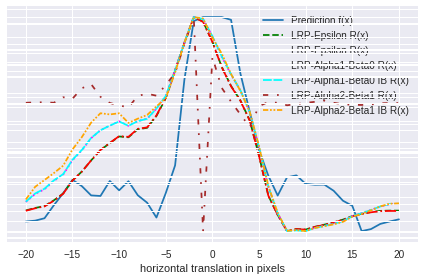

In [36]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('horizontal translation in pixels')
label = "Prediction f(x)"
axlegend =ax1.plot(x, avg_preds, label=label, color="tab:blue")
ax1.tick_params(axis='y', bottom=False, top=False, labelbottom=False, which='both', length=0)
ax1.set_yticklabels([])

twin_ax = []
helper_axes = []
linestyles = ['--', '-.', ':',(0, (5, 1)),(0, (3, 5, 1, 5)),(0, (3, 1, 1, 1, 1, 1))]
colors = ["green", "red", "magenta", "cyan", "brown", "orange"]
for aidx,method_name in enumerate(selected_methods):
    twin_ax.append(ax1.twinx())
    twin_ax[aidx].tick_params(axis='y', bottom=False, top=False, labelbottom=False, which='both', length=0)
    twin_ax[aidx].set_yticklabels([])
    label = "{} R(x)".format(method_name[3])
    helper_axes.append(twin_ax[aidx].plot(x, avg_analysis[aidx], label=label, linestyle=linestyles[aidx], color=colors[aidx]))

lns = axlegend
for tmp in helper_axes:
   lns = lns + tmp
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

fig.tight_layout()
plt.show()
